In [11]:
import requests
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
import os

In [12]:
# Função para salvar e carregar dados intermediários
# ==================================================

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def load_from_csv(filename):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    return None

In [19]:
# Parte 1: Minerar Repositórios do GitHub
# ========================================

def search_repositories(query, language, min_stars, per_page=30, max_pages=2):
    headers = {"Accept": "application/vnd.github.v3+json"}
    base_url = "https://api.github.com/search/repositories"
    repositories = []

    for page in range(1, max_pages + 1):
        params = {
            "q": f"{query} language:{language} stars:>={min_stars}",
            "sort": "stars",
            "order": "desc",
            "per_page": per_page,
            "page": page,
        }
        response = requests.get(base_url, headers=headers, params=params)
        if response.status_code != 200:
            print(f"Erro na API do GitHub: {response.json()}")
            break

        items = response.json().get("items", [])
        repositories.extend([repo.get("clone_url", "") for repo in items if repo.get("clone_url")])

    return repositories

manual_repos = [
    "https://github.com/python/cpython.git",
    "https://github.com/huggingface/transformers.git",
    "https://github.com/pytorch/pytorch.git",
    "https://github.com/langchain-ai/langchain.git"
]

repos = load_from_csv('repos.csv')

if repos is not None:
    repos = repos['clone_url'].tolist()
else:
    repos = search_repositories(query="", language="Python", min_stars=500, max_pages=3)
    save_to_csv([{'clone_url': url} for url in repos], 'repos.csv')

all_repos = manual_repos + repos

In [20]:
# Parte 2: Classificar os Repositórios
# ====================================

def filter_repos_with_contributors(repo_urls, min_contributors):
    contributors_count = []

    for repo_url in repo_urls:
        contributors = set()
        try:
            for commit in Repository(repo_url, since=datetime(2021, 1, 1)).traverse_commits():
                if commit.author and commit.author.email:
                    contributors.add(commit.author.email)
        except Exception as e:
            print(f"Erro ao processar {repo_url}: {e}")
            continue

        if len(contributors) >= min_contributors:
            contributors_count.append({"Repository": repo_url, "Contributors": len(contributors)})

    return pd.DataFrame(contributors_count)

contributors_df = load_from_csv('contributors_data.csv')
if contributors_df is None or contributors_df.empty:
    contributors_df = filter_repos_with_contributors(all_repos, min_contributors=5)
    save_to_csv(contributors_df, 'contributors_data.csv')

if not contributors_df.empty:
    percentile_50 = contributors_df["Contributors"].quantile(0.5)
    high_contributors = contributors_df[contributors_df["Contributors"] > percentile_50]
    medium_contributors = contributors_df[contributors_df["Contributors"] <= percentile_50]
else:
    high_contributors = pd.DataFrame(columns=["Repository", "Contributors"])
    medium_contributors = pd.DataFrame(columns=["Repository", "Contributors"])

In [21]:
# Parte 3: Analisar Testes de Software
# ====================================

def analyze_testing_patterns(repo_url):
    test_commits = []

    for i, commit in enumerate(Repository(repo_url, since=datetime(2021, 1, 1)).traverse_commits(), start=1):
        if i % 100 == 0:
            print(f"Processed {i} commits in {repo_url}")
        for file in commit.modified_files:
            if file.filename and "test" in file.filename.lower():
                test_commits.append(commit.hash)

    return {
        "Repository": repo_url,
        "TotalCommits": len(test_commits),
        "TestCommits": test_commits
    }

def analyze_repositories_parallel(repo_urls, output_file):
    results = []

    def analyze_repo(repo_url):
        try:
            return analyze_testing_patterns(repo_url)
        except Exception as e:
            print(f"Erro ao analisar {repo_url}: {e}")
            return None

    max_workers = min(32, (os.cpu_count() or 1) + 4)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_repo = {executor.submit(analyze_repo, repo): repo for repo in repo_urls}
        for future in future_to_repo:
            result = future.result()
            if result:
                results.append(result)

    df = pd.DataFrame(results)
    save_to_csv(df, output_file)
    return df

high_analysis_results = load_from_csv('high_analysis_results.csv')
if high_analysis_results is None or high_analysis_results.empty:
    high_analysis_results = analyze_repositories_parallel(high_contributors["Repository"].tolist(), 'high_analysis_results.csv')

medium_analysis_results = load_from_csv('medium_analysis_results.csv')
if medium_analysis_results is None or medium_analysis_results.empty:
    medium_analysis_results = analyze_repositories_parallel(medium_contributors["Repository"].tolist(), 'medium_analysis_results.csv')

analysis_results = pd.concat([high_analysis_results, medium_analysis_results], ignore_index=True)

Processed 100 commits in https://github.com/josephmisiti/awesome-machine-learning.git
Processed 100 commits in https://github.com/public-apis/public-apis.git
Processed 200 commits in https://github.com/public-apis/public-apis.git
Processed 200 commits in https://github.com/josephmisiti/awesome-machine-learning.git
Processed 300 commits in https://github.com/public-apis/public-apis.git
Processed 300 commits in https://github.com/josephmisiti/awesome-machine-learning.git
Processed 100 commits in https://github.com/AUTOMATIC1111/stable-diffusion-webui.git
Processed 400 commits in https://github.com/public-apis/public-apis.git
Processed 100 commits in https://github.com/TheAlgorithms/Python.git
Processed 100 commits in https://github.com/fastapi/fastapi.git
Processed 400 commits in https://github.com/josephmisiti/awesome-machine-learning.git
Processed 500 commits in https://github.com/public-apis/public-apis.git
Processed 100 commits in https://github.com/yt-dlp/yt-dlp.git
Processed 200 co

C:\Users\vazle\AppData\Local\Temp\ipykernel_70120\2521242404.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


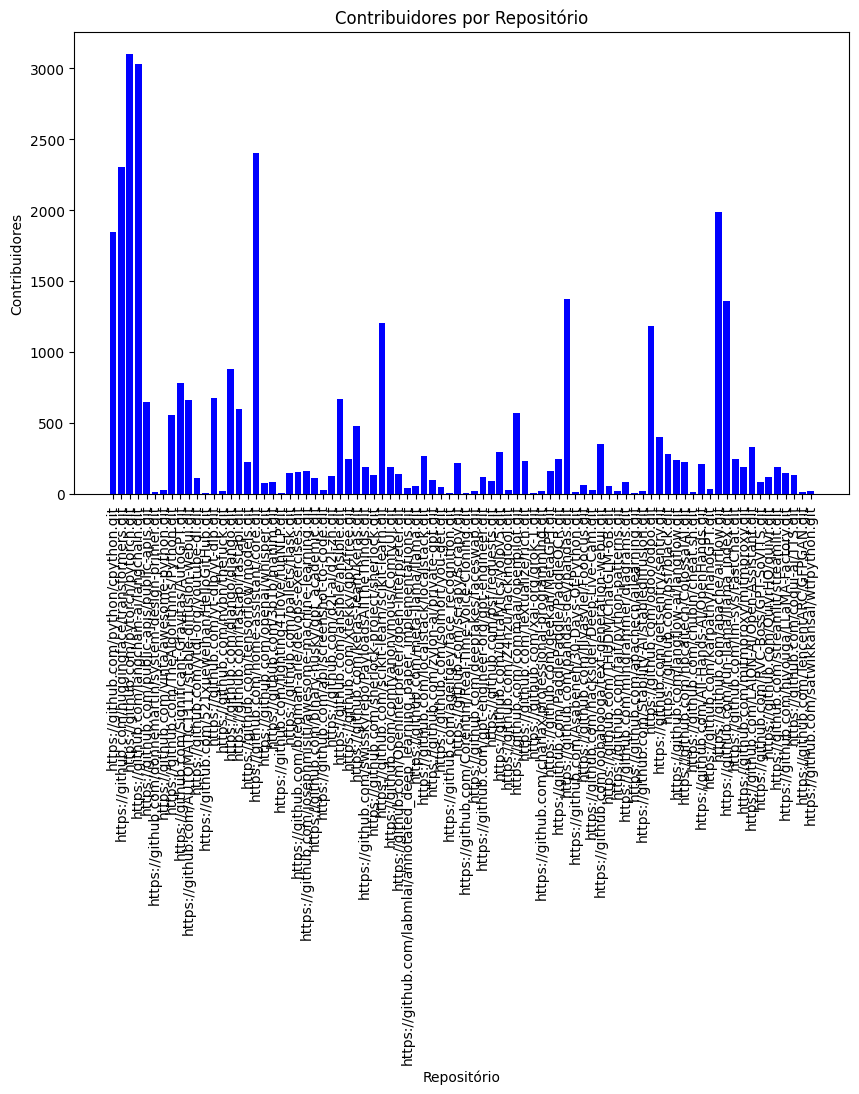

C:\Users\vazle\AppData\Local\Temp\ipykernel_70120\2521242404.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


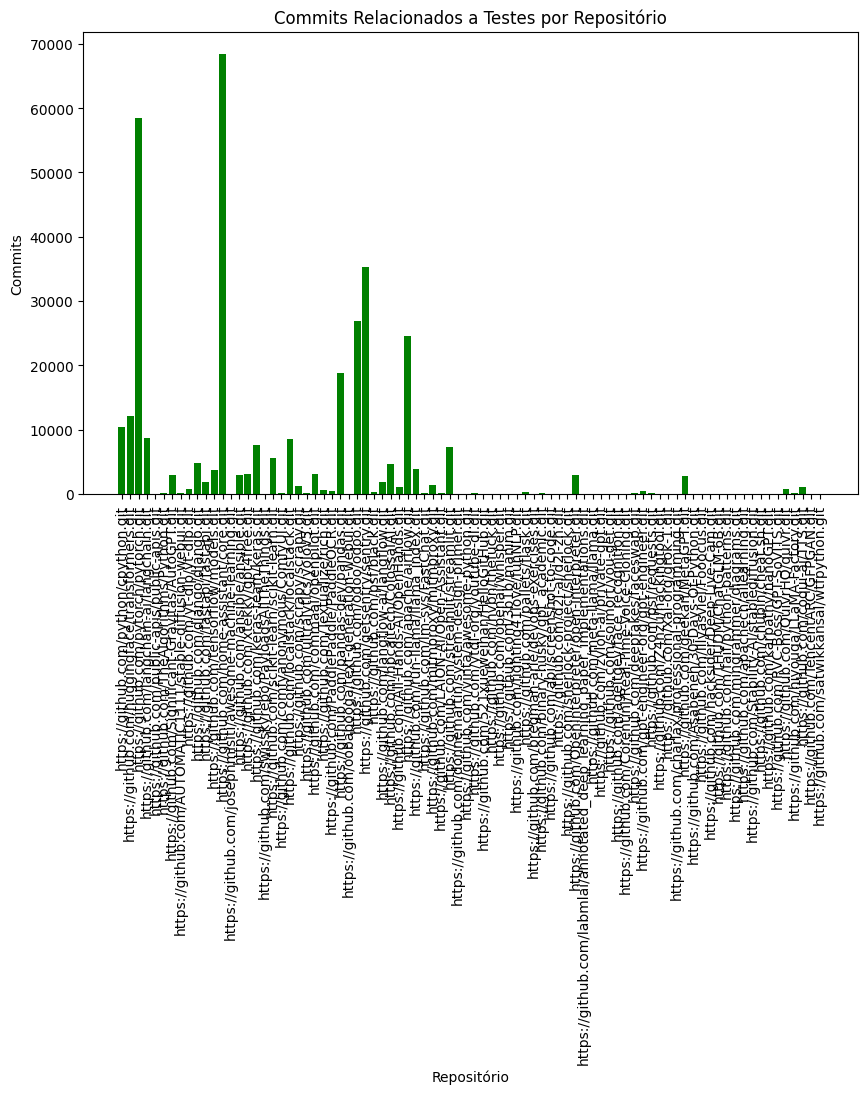

In [23]:
# Parte 4: Visualização
# ======================

def visualize_results(contributors_df, analysis_results):
    if not contributors_df.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(contributors_df["Repository"], contributors_df["Contributors"], color="blue")
        plt.title("Contribuidores por Repositório")
        plt.ylabel("Contribuidores")
        plt.xlabel("Repositório")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    if not analysis_results.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(analysis_results["Repository"], analysis_results["TotalCommits"], color="green")
        plt.title("Commits Relacionados a Testes por Repositório")
        plt.ylabel("Commits")
        plt.xlabel("Repositório")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

visualize_results(contributors_df, analysis_results)